In [1]:
import numpy as np
np.random.seed(42)
import sys
import cProfile
import h5py
sys.path.insert(0, '../..')
%reload_ext memory_profiler
%reload_ext autoreload
%autoreload 1
import allel; print(allel.__version__)
%aimport allel.stats.selection

0.21.0.dev0


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
callset = h5py.File('/data/coluzzi/ag1000g/data/phase1/release/AR3/haplotypes/main/hdf5/ag1000g.phase1.ar3.haplotypes.3R.h5',
                    mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.haplotypes.3R.h5" (mode r)>

In [4]:
n_variants = 100000
n_samples = 50

In [5]:
h1 = allel.GenotypeArray(callset['3R']['calldata/genotype'][:n_variants, :n_samples]).to_haplotypes()
h1

,0,1,2,3,4,...,95,96,97,98,99
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [6]:
h2 = allel.GenotypeArray(callset['3R']['calldata/genotype'][:n_variants, -n_samples:]).to_haplotypes()
h2

,0,1,2,3,4,...,95,96,97,98,99
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [7]:
pos = callset['3R']['variants/POS'][:n_variants]
pos

array([  1252,   1262,   1271, ..., 554764, 554768, 554770], dtype=int32)

In [8]:
ac1 = h1.count_alleles(max_allele=1)
ac2 = h2.count_alleles(max_allele=1)
ac = allel.AlleleCountsArray(ac1 + ac2)
is_seg = ac.is_segregating() & (ac.min(axis=1) > 1)
h1_seg = h1.compress(is_seg, axis=0)
h2_seg = h2.compress(is_seg, axis=0)
pos_seg = pos.compress(is_seg)
ac_seg = ac.compress(is_seg, axis=0)
ac1_seg = ac1.compress(is_seg, axis=0)
ac2_seg = ac2.compress(is_seg, axis=0)
np.count_nonzero(is_seg)

19897

In [9]:
%%time
score = allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0, include_edges=True)

CPU times: user 6.72 s, sys: 4 ms, total: 6.73 s
Wall time: 6.72 s


In [10]:
%%time
score = allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0.05, include_edges=True)

CPU times: user 1.69 s, sys: 4 ms, total: 1.69 s
Wall time: 1.69 s


In [11]:
score

array([        nan, -0.34142822, -0.42965751, ..., -0.21550515,
       -0.20973783,         nan])

In [12]:
np.count_nonzero(np.isnan(score)), np.count_nonzero(~np.isnan(score))

(2, 19895)

In [13]:
np.count_nonzero(np.isinf(score)), np.count_nonzero(~np.isinf(score))

(0, 19897)

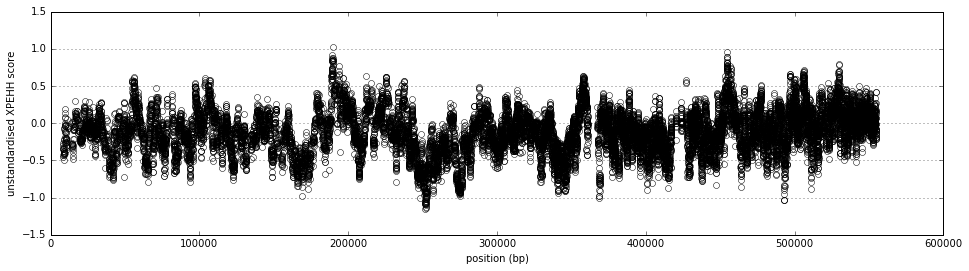

In [14]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('unstandardised XPEHH score');

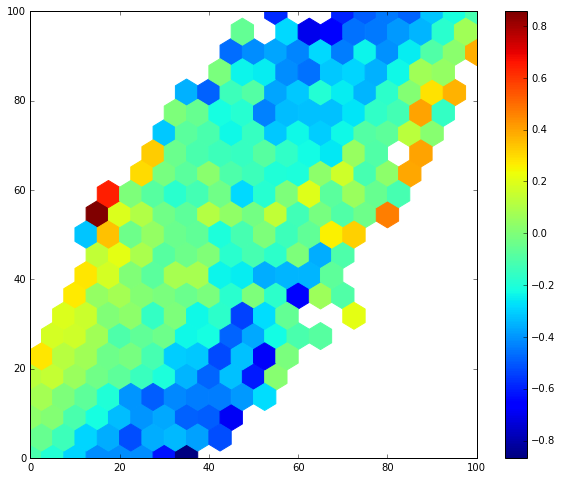

In [15]:
x = ac1_seg[:, 1]
y = ac2_seg[:, 1]
C = score
plt.figure(figsize=(10, 8))
plt.hexbin(x, y, C, gridsize=20)
plt.colorbar();

In [16]:
import scipy as sp
import scipy.stats

In [17]:
bins = np.arange(0, n_samples*2 + 1, 10)
mean_ihs_by_aac, _, _, mean_ihs_bn = sp.stats.binned_statistic_2d(ac1_seg[:, 1], ac2_seg[:, 1], score, 
                                                                  statistic=np.nanmean, bins=bins)
std_ihs_by_aac, _, _, std_ihs_bn = sp.stats.binned_statistic_2d(ac1_seg[:, 1], ac2_seg[:, 1], score, 
                                                                statistic=np.nanstd, bins=bins)

In [18]:
hst, _, _ = np.histogram2d(ac1_seg[:, 1], ac2_seg[:, 1], bins=bins)

In [19]:
hst[-1, -1]

331.0

In [20]:
hst[0, -1]

0.0

In [21]:
mean_ihs_by_aac[2, -1]

nan

In [22]:
bins

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [23]:
mean_ihs_by_aac.shape

(10, 10)

In [24]:
mean_ihs_by_aac.shape, std_ihs_by_aac.shape

((10, 10), (10, 10))

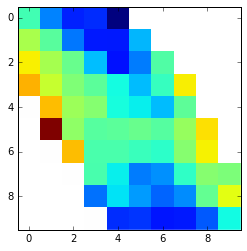

In [25]:
plt.imshow(mean_ihs_by_aac.T, interpolation='none');

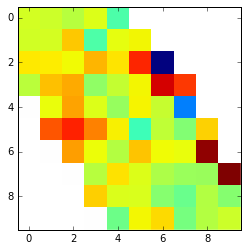

In [26]:
plt.imshow(std_ihs_by_aac.T, interpolation='none');

In [27]:
score_centred = np.zeros_like(score)
score_normed = np.zeros_like(score)

In [28]:
bins

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [29]:
score.shape

(19897,)

In [30]:
score_centred.shape

(19897,)

In [31]:
x = ac1_seg[:, 1]
y = ac2_seg[:, 1]
for i in range(len(bins) - 1):
    for j in range(len(bins) - 1):
        x1 = bins[i]
        x2 = bins[i + 1]
        y1 = bins[j]
        y2 = bins[j + 1]
        if i+1 == len(bins) - 1:
            locx = (x >= x1) & (x <= x2)
        else:
            locx = (x >= x1) & (x < x2)
        if j+1 == len(bins) - 1:
            locy = (y >= y1) & (y <= y2)
        else:
            locy = (y >= y1) & (y < y2)
        loc = locx & locy
        if np.count_nonzero(loc):
            m = mean_ihs_by_aac[i, j]
            s = std_ihs_by_aac[i, j]
            print(i, j, x1, x2, y1, y2, np.count_nonzero(loc), m, s)
            score_centred[loc] = score[loc] - m
            score_normed[loc] = score_centred[loc] / s

0 0 0 10 0 10 13148 -0.105056741473 0.268628807148
0 1 0 10 10 20 995 0.0408092331239 0.267639037645
0 2 0 10 20 30 148 0.158316980498 0.292954017608
0 3 0 10 30 40 36 0.232601371903 0.254890039749
1 0 10 20 0 10 657 -0.310614640748 0.265012922647
1 1 10 20 10 20 464 -0.0732339616725 0.268730931476
1 2 10 20 20 30 321 0.0394700533579 0.291797797958
1 3 10 20 30 40 141 0.0832345311341 0.312480768573
1 4 10 20 40 50 53 0.220004609534 0.28153449673
1 5 10 20 50 60 6 0.560898408806 0.361963537784
2 0 20 30 0 10 182 -0.424561108496 0.253692395926
2 1 20 30 10 20 141 -0.321745391591 0.309022907102
2 2 20 30 20 30 121 -0.0493971354161 0.284234519239
2 3 20 30 30 40 148 -0.0156346528229 0.322486823525
2 4 20 30 40 50 125 0.0251713505815 0.326541054439
2 5 20 30 50 60 76 0.00870386484544 0.386179035812
2 6 20 30 60 70 21 0.221375539579 0.327722225965
3 0 30 40 0 10 71 -0.40736840759 0.274302843956
3 1 30 40 10 20 110 -0.430739728037 0.196656783067
3 2 30 40 20 30 51 -0.238373237098 0.3166163737

In [32]:
np.count_nonzero(np.isnan(score_centred))

2

In [33]:
np.count_nonzero(np.isnan(score_normed))

3

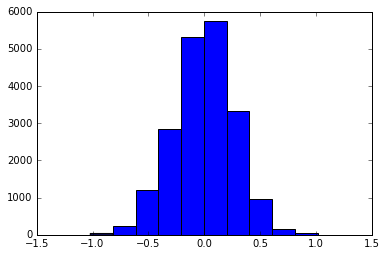

In [34]:
plt.hist(score_centred[~np.isnan(score)]);

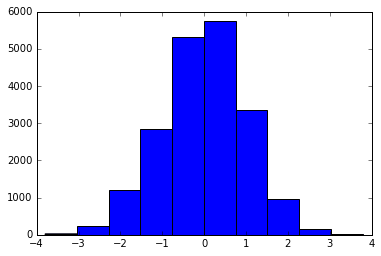

In [35]:
plt.hist(score_normed[~np.isnan(score_normed)]);

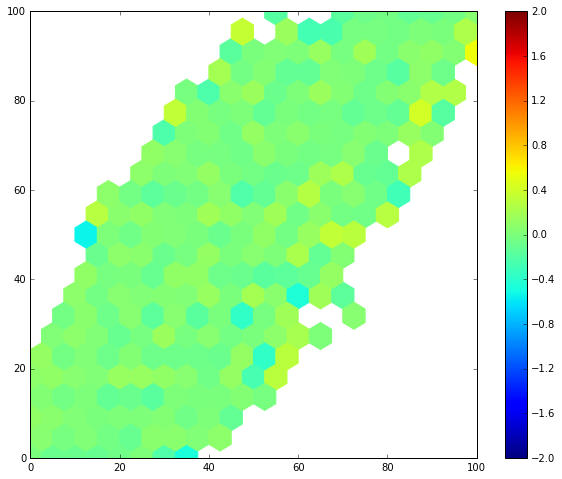

In [36]:
x = ac1_seg[:, 1]
y = ac2_seg[:, 1]
C = score_centred
plt.figure(figsize=(10, 8))
plt.hexbin(x, y, C, gridsize=20, vmin=-2, vmax=2)
plt.colorbar();

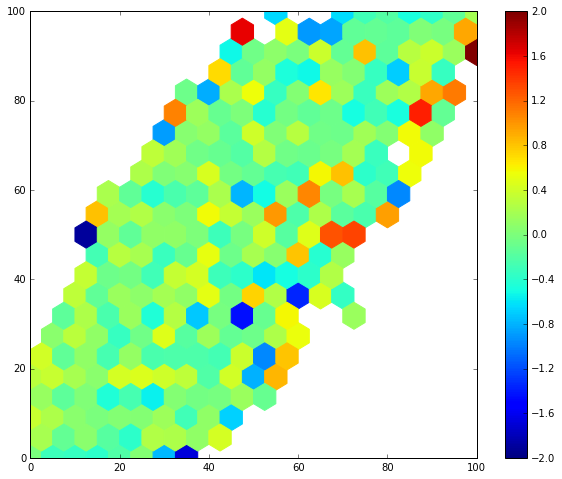

In [37]:
x = ac1_seg[:, 1]
y = ac2_seg[:, 1]
C = score_normed
plt.figure(figsize=(10, 8))
plt.hexbin(x, y, C, gridsize=20, vmin=-2, vmax=2)
plt.colorbar();

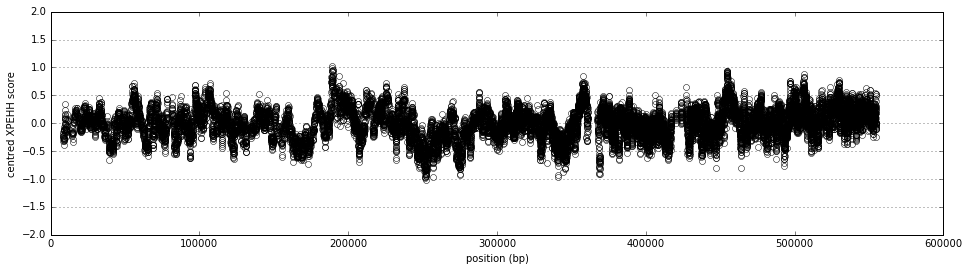

In [38]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score_centred, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('centred XPEHH score')
plt.ylim(-2, 2);

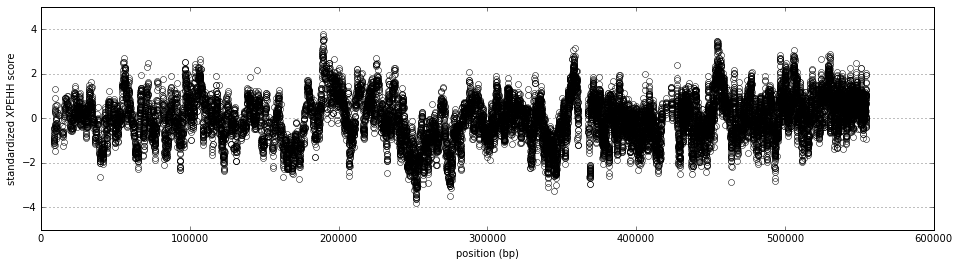

In [39]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score_normed, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('standardized XPEHH score')
plt.ylim(-5, 5);

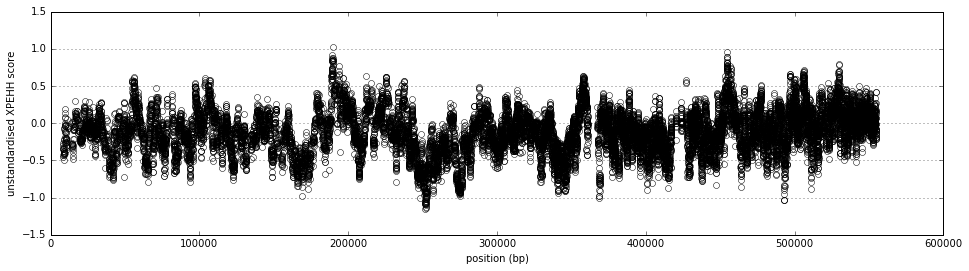

In [40]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('unstandardised XPEHH score');

In [41]:
cProfile.run('allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0.05, include_edges=True)', sort='time')

         1830664 function calls in 2.710 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    79588    1.534    0.000    1.776    0.000 stats.pyx:414(ssl2ihh)
        4    0.732    0.183    2.708    0.677 stats.pyx:499(ihh_scan_int8)
   238768    0.198    0.000    0.245    0.000 stringsource:985(memoryview_fromslice)
   318372    0.108    0.000    0.108    0.000 stringsource:341(__cinit__)
    79604    0.040    0.000    0.117    0.000 stringsource:643(memoryview_cwrapper)
   318372    0.035    0.000    0.035    0.000 stringsource:368(__dealloc__)
   238780    0.020    0.000    0.020    0.000 stringsource:649(memoryview_check)
   238768    0.018    0.000    0.018    0.000 stringsource:962(__dealloc__)
   159180    0.011    0.000    0.011    0.000 stringsource:545(__get__)
    79592    0.006    0.000    0.006    0.000 stringsource:507(__getbuffer__)
    79588    0.005    0.000    0.005    0.000 stringsource:978(__get__)
      